### Imports

In [1]:
import os
import sys
import glob
import csv
import time
import platform
import socket
import random
from datetime import datetime
from tqdm.auto import tqdm
from typing import Tuple, List, Callable

c:\Users\Aidan\.conda\envs\py310_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from PIL import Image
import psutil  # For system resource monitoring
# import GPUtil  # For GPU information
import wandb

In [3]:
import torch
from torch import nn
import torch.optim as optim
from torchvision.io import decode_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor

### Constants

In [4]:
from displacements import VectorFieldComposer, VECTOR_FIELDS

TILES_DIR = "../tiles"
# TILE_IMAGE_PATHS = glob.glob(os.path.join(TILES_DIR, "**/*.png"), recursive=True)
TILE_IMAGE_PATHS = glob.glob(os.path.join(TILES_DIR, "g*/**/*.png"), recursive=True) # Just the graphite images
MAX_TILES = 50000
NUM_TILES = min(MAX_TILES, len(TILE_IMAGE_PATHS))

TILE_SIZE = 256

# Dataset

In [5]:
class CustomDataset(Dataset):
    def __init__(self, variations_per_image: int = 10):
        self.variations_per_image = variations_per_image
    
    def __len__(self):
        return NUM_TILES * self.variations_per_image

    def __getitem__(self, index):
        # Indexes work like this:
        # [1_0, ..., n_0, 1_1, ..., n_1, 1_v, ..., n_v, ...]
        # [1  , ..., n  , n+1, ..., n+n, vn+1,..., vn+n,...]
        # Where n is the number of images
        # And v is the variation number
        
        # Get the image index
        path_index = index % NUM_TILES
        variation = index // self.variations_per_image

        random.seed(variation)

        composer = VectorFieldComposer()
            
        available_fields = list(VECTOR_FIELDS.keys())
        num_fields = random.randint(1, 3)
        for _ in range(num_fields):
            field_type = random.choice(available_fields)
            composer.add_field(field_type, randomize=True)
        
        image = np.array(Image.open(TILE_IMAGE_PATHS[path_index], mode="r"))
        image2 = composer.apply_to_image(image)

        grid_X, grid_Y = np.meshgrid(np.linspace(-1, 1, TILE_SIZE), np.linspace(-1, 1, TILE_SIZE))
        dx, dy = composer.compute_combined_field(grid_X, grid_Y)

        # return image.astype(np.float32), dx.astype(np.float32)
        return np.array([image, image2]).astype(np.float32), np.array([dx, dy]).astype(np.float32)

In [6]:
VARIATIONS_PER_IMAGE = 10
EPOCHS = 10
BATCH_SIZE = 64
IMG_SIZE = TILE_SIZE
LEARNING_RATE = 0.0001
SAVE_FREQUENCY = 5

SAVE_FOLDER = "model2"
MODEL_NUMBER = 1
MODEL_FILE = f"{SAVE_FOLDER}/tx{1}.pth"

while os.path.exists(MODEL_FILE):
    MODEL_NUMBER += 1
    MODEL_FILE = f"{SAVE_FOLDER}/tx{MODEL_NUMBER}.pth"

MODEL_NAME = MODEL_FILE.replace("/", "_").replace(".pth", "")

if not os.path.exists(SAVE_FOLDER): 
    os.makedirs(SAVE_FOLDER)

In [7]:
training_dataset = CustomDataset(VARIATIONS_PER_IMAGE)
validation_dataset = CustomDataset(VARIATIONS_PER_IMAGE)

training_dataloader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE)

for x, y in training_dataloader:
    print(f"Shape of X [N, C, H, W]: {x.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 2, 256, 256])
Shape of y: torch.Size([64, 2, 256, 256]) torch.float32


# Model

In [8]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [9]:
class ConvolutionBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1, inplace=True),
        )

        self.residual = nn.Sequential()
        if in_channels != out_channels:
            self.residual = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        # i learned about this in class today! the timing in on point!
        return self.conv(x) + self.residual(x)

class MotionVectorRegressionNetwork(nn.Module):
    def __init__(self, input_images = 2):
        super().__init__()
        # Outputs an xy motion vector per pixel
        self.input_images = input_images
        self.vector_channels = 2

        self.convolution = nn.Sequential(
            ConvolutionBlock(input_images, 32, kernel_size=3), # input_images (2) -> 32 channels
            nn.MaxPool2d(kernel_size=2), # scales down by half

            ConvolutionBlock(32, 64, kernel_size=3), # 32 -> 64 channels
            nn.MaxPool2d(kernel_size=2), # scales down by half

            ConvolutionBlock(64, 128, kernel_size=3), # 64 -> 128 channels 
            ConvolutionBlock(128, 128, kernel_size=3), # 128 -> 128 channels
        ) 

        self.output = nn.Sequential(
            # scale back up
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1), # 128 -> 64 channels
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1), # 64 -> 32 channels
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, self.vector_channels, kernel_size=3, stride=1, padding=1), # 32 -> 2 channels
        )

    def forward(self, x):
        # print(x.shape)
        x = self.convolution(x)
        # print(x.shape)
        x = self.output(x)
        # print(x.shape)
        return x

model = MotionVectorRegressionNetwork(input_images=2).to(device)
print(model)

MotionVectorRegressionNetwork(
  (convolution): Sequential(
    (0): ConvolutionBlock(
      (conv): Sequential(
        (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
      )
      (residual): Sequential(
        (0): Conv2d(2, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ConvolutionBlock(
      (conv): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
      )
      (residual): Sequential(
        (0):

In [10]:
def custom_loss(predicted_vectors, target_vectors):
    # print(predicted_vectors.shape)
    # print(target_vectors.shape)
    l1_loss = nn.functional.l1_loss(predicted_vectors, target_vectors)

    # some extra leniency to the loss by checking the neighboring pixels
    # print(predicted_vectors.shape)
    x_dir = predicted_vectors[:, :, 1:]
    neighbor_x = predicted_vectors[:, :, :-1]

    y_dir = predicted_vectors[:, :, :, 1:]
    neighbor_y = predicted_vectors[:, :, :, :-1]

    diff_x = torch.abs(x_dir - neighbor_x)
    diff_y = torch.abs(y_dir - neighbor_y)

    # print(diff_x.shape)
    # print(diff_y.shape)
    diff_x = diff_x.mean()
    # print(diff_x)
    diff_y = diff_y.mean()

    smoothening_value = diff_x + diff_y
    # print(smoothening_value)
    return l1_loss
    # return l1_loss + 0.1 * smoothening_value

In [11]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=5)

In [12]:
run = wandb.init(
    # mode="offline",
    
    # set the wandb project where this run will be logged
    project="motion-model",

    # track hyperparameters and run metadata
    name=MODEL_NAME,
    config={
        "learning_rate": LEARNING_RATE,
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE,
        "architecture": "MotionVectorRegressionNetwork",
        "dataset": {
            "train": len(training_dataset),
            "val": len(validation_dataset),
        },
        "loss_function": "L1",
        "optimizer": "Adam",
        "scheduler": {
            "type": "ReduceLROnPlateau",
                "factor": 0.1,
                "patience": 5,
                "mode": "min",
                "threshold": 0.0001,
        },
    }
)

wandb.watch(model, log="all", log_freq=100)
print(run.name)

wandb: Currently logged in as: aidanschmitigal (osu-enhancing-deformation-analysis) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


model2_tx7


In [13]:
# ebar = tqdm(total = EPOCHS, desc="Epochs", position=1)
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}\n-------------------------------")
    model.train()
    epoch_training_losses = []

    size = len(training_dataloader)
    milestone = 0
    # with tqdm(total=size, desc=f"{epoch+1}/{EPOCHS} Batch:", position=0) as pbar:
    for batch, (batch_images, batch_vectors) in enumerate(training_dataloader):
        batch_images, batch_vectors = batch_images.to(device), batch_vectors.to(device)

        # Compute prediction error
        pred = model(batch_images)
        loss = custom_loss(pred, batch_vectors)

        # Backpropagation
        loss.backward()

        total_grads = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        optimizer.zero_grad()

        wandb.log({
            "batch/train_loss": loss.item(),
            "batch/gradient_norm": total_grads,
            "batch/learning_rate": optimizer.param_groups[0]['lr']
        })

    
        epoch_training_losses.append(loss.item())
        # pbar.set_postfix(loss=loss.item())
        # pbar.update(1)
        # ebar.update(1/size)

        if batch > (milestone * 100):
            milestone += 1
            print(f"loss: { loss.item():>7f}  [{batch:>5d}/{size:>5d}]")
    
    model.eval()
    validation_losses = []
    
    with torch.no_grad():
        for batch, (batch_images, batch_vectors) in enumerate(validation_dataloader):
            batch_images, batch_vectors = batch_images.to(device), batch_vectors.to(device)
            
            pred = model(batch_images)
            loss = custom_loss(pred, batch_vectors)
            validation_losses.append(loss.item())

    average_trianing_loss = np.mean(epoch_training_losses)
    average_validation_loss = np.mean(validation_losses)

    # ebar.reset(epoch)

    wandb.log({
        "epoch": epoch,
        "epoch/training_loss": average_trianing_loss,
        "epoch/validation_loss": average_validation_loss,
        "epoch/learning_rate": optimizer.param_groups[0]['lr']
    })

    # if epoch % SAVE_FREQUENCY == 0:
    with torch.no_grad():
        torch.save(model.state_dict(), "snapshot_save.pt")

        for i, (batch_images, batch_vectors) in enumerate(iter(validation_dataloader)):
            if (i > 4): break;

            sample_predictions = model(batch_images.to(device))
            
            converted_y = batch_vectors[0].cpu().numpy()
            converted_y = np.vstack((converted_y, np.zeros((1, converted_y.shape[1], converted_y.shape[2]))))
            converted_y = np.transpose(converted_y, (1, 2, 0))
            converted_y = (converted_y - converted_y.min()) / (converted_y.max() - converted_y.min())

            converted_pred = sample_predictions[0].cpu().numpy()
            converted_pred = np.vstack((converted_pred, np.zeros((1, converted_pred.shape[1], converted_pred.shape[2]))))
            converted_pred = np.transpose(converted_pred, (1, 2, 0))
            converted_pred = (converted_pred - converted_pred.min()) / (converted_pred.max() - converted_pred.min())

            base_image = np.array((batch_images[0, 0].cpu().numpy(),)*3)
            base_image = np.transpose(base_image, (1, 2, 0))
            morph_image = np.array((batch_images[0, 1].cpu().numpy(),)*3)
            morph_image = np.transpose(morph_image, (1, 2, 0))
            combined = np.hstack((base_image, morph_image, converted_y * 256, converted_pred * 256)).astype(np.uint8)  

            wandb.log({
                f"samples/sample_{i}": wandb.Image(combined, caption=f"Epoch: {epoch}"),
            })
    
    scheduler.step(average_validation_loss)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {average_trianing_loss:.4f}")
    print(f"Val Loss: {average_validation_loss:.4f}")

model_artifact = wandb.Artifact(
    name=f"motion_vector_model_{run.id}",
    type="model",
    description="Trained motion vector model"
)

torch.save(model.state_dict(), MODEL_FILE)
model_artifact.add_file(MODEL_FILE)
wandb.log_artifact(model_artifact)

wandb.finish()

print(f"Model saved to {MODEL_FILE}")
print("Done!")

Epoch 1
-------------------------------
loss: 1.175514  [    1/ 2744]
loss: 0.600333  [  101/ 2744]
loss: 0.422102  [  201/ 2744]
loss: 0.341934  [  301/ 2744]
loss: 0.384919  [  401/ 2744]
loss: 0.410311  [  501/ 2744]
loss: 0.348578  [  601/ 2744]
loss: 0.321670  [  701/ 2744]
loss: 0.294421  [  801/ 2744]
loss: 0.237883  [  901/ 2744]
loss: 0.206208  [ 1001/ 2744]
loss: 0.251112  [ 1101/ 2744]
loss: 0.206077  [ 1201/ 2744]
loss: 0.294807  [ 1301/ 2744]
loss: 0.257996  [ 1401/ 2744]
loss: 0.219317  [ 1501/ 2744]
loss: 0.243908  [ 1601/ 2744]
loss: 0.152635  [ 1701/ 2744]
loss: 0.211860  [ 1801/ 2744]
loss: 0.209406  [ 1901/ 2744]
loss: 0.192145  [ 2001/ 2744]
loss: 0.198040  [ 2101/ 2744]
loss: 0.169619  [ 2201/ 2744]
loss: 0.167025  [ 2301/ 2744]
loss: 0.214184  [ 2401/ 2744]
loss: 0.181993  [ 2501/ 2744]
loss: 0.183743  [ 2601/ 2744]
loss: 0.180974  [ 2701/ 2744]
Epoch 1/10
Train Loss: 0.2807
Val Loss: 0.1563
Epoch 2
-------------------------------
loss: 0.190834  [    1/ 2744]
los

Model saved to model2/tx7.pth
Done!


# Testing

In [14]:
# testin gthe model

model = MotionVectorRegressionNetwork().to(device)
model.load_state_dict(torch.load(MODEL_FILE, weights_only=True))

<All keys matched successfully>

1
torch.Size([64, 2, 256, 256]) torch.Size([64, 2, 256, 256]) torch.Size([64, 2, 256, 256])
(256, 256)
0 255


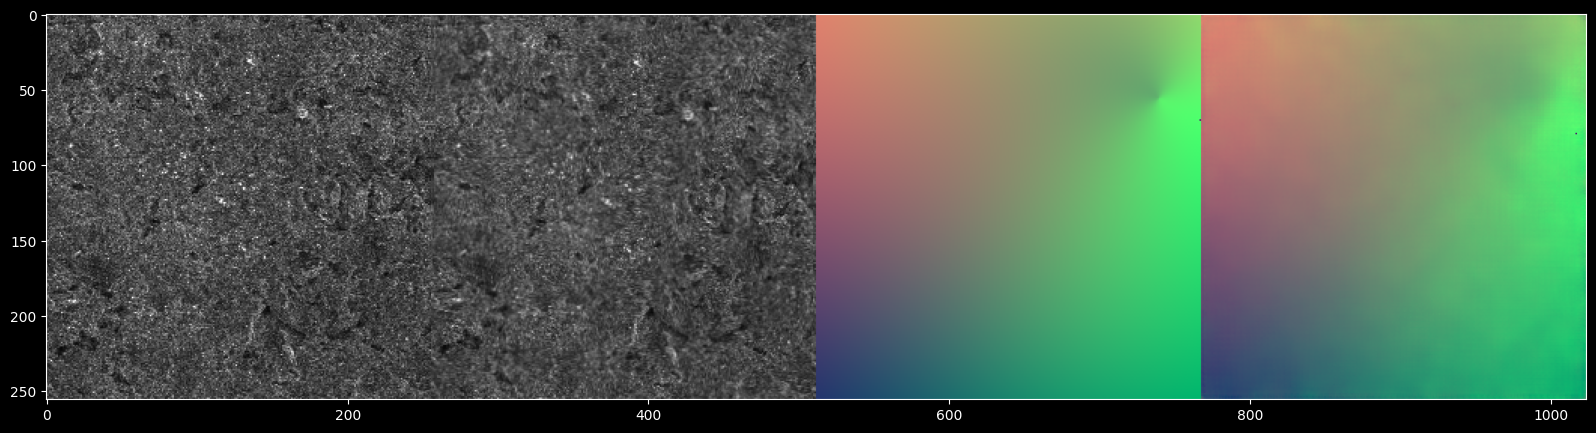

2
torch.Size([64, 2, 256, 256]) torch.Size([64, 2, 256, 256]) torch.Size([64, 2, 256, 256])
(256, 256)
0 255


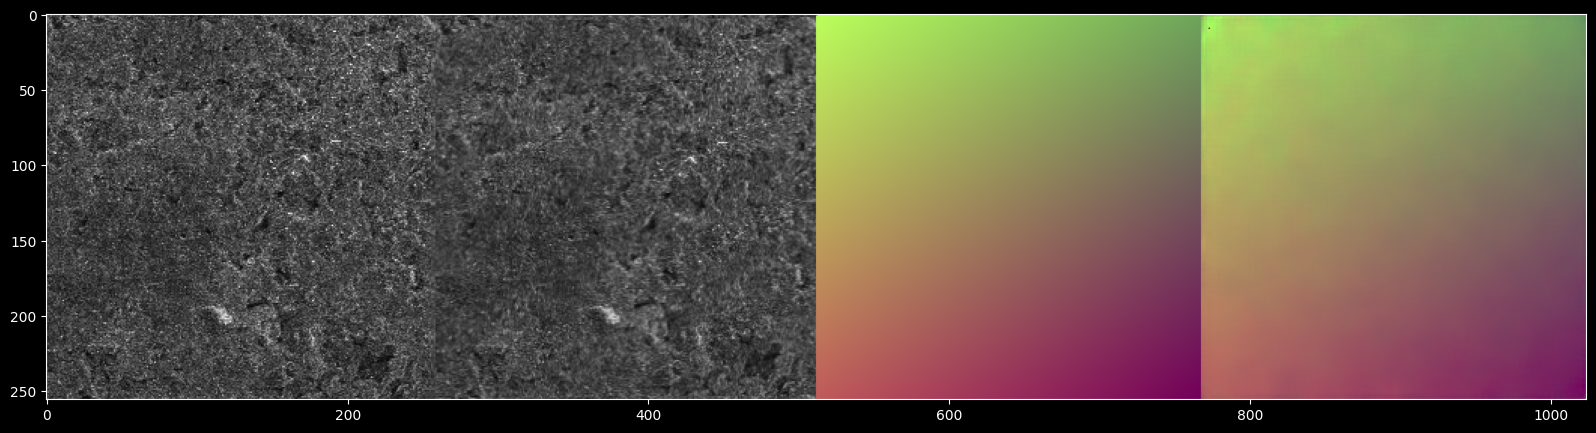

3
torch.Size([64, 2, 256, 256]) torch.Size([64, 2, 256, 256]) torch.Size([64, 2, 256, 256])
(256, 256)
0 255


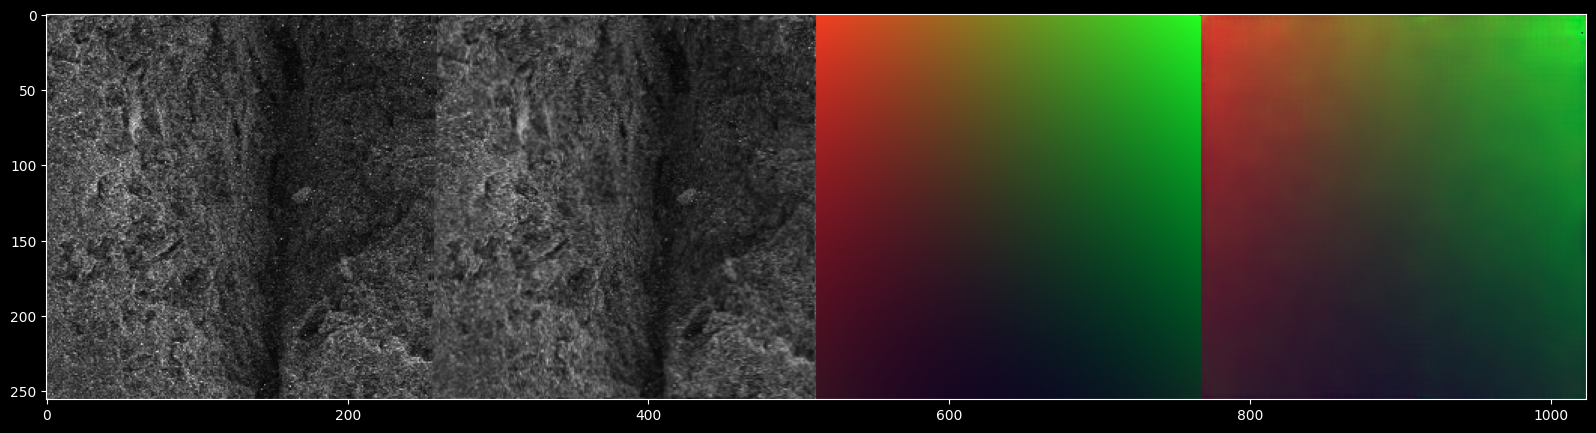

4
torch.Size([64, 2, 256, 256]) torch.Size([64, 2, 256, 256]) torch.Size([64, 2, 256, 256])
(256, 256)
0 255


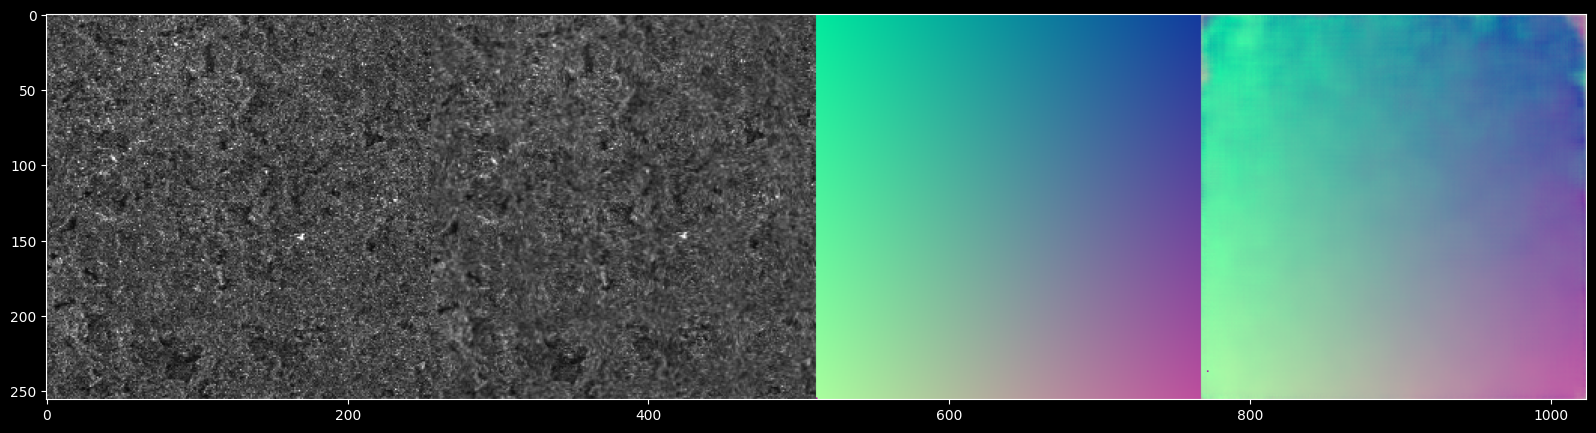

5
torch.Size([64, 2, 256, 256]) torch.Size([64, 2, 256, 256]) torch.Size([64, 2, 256, 256])
(256, 256)
0 255


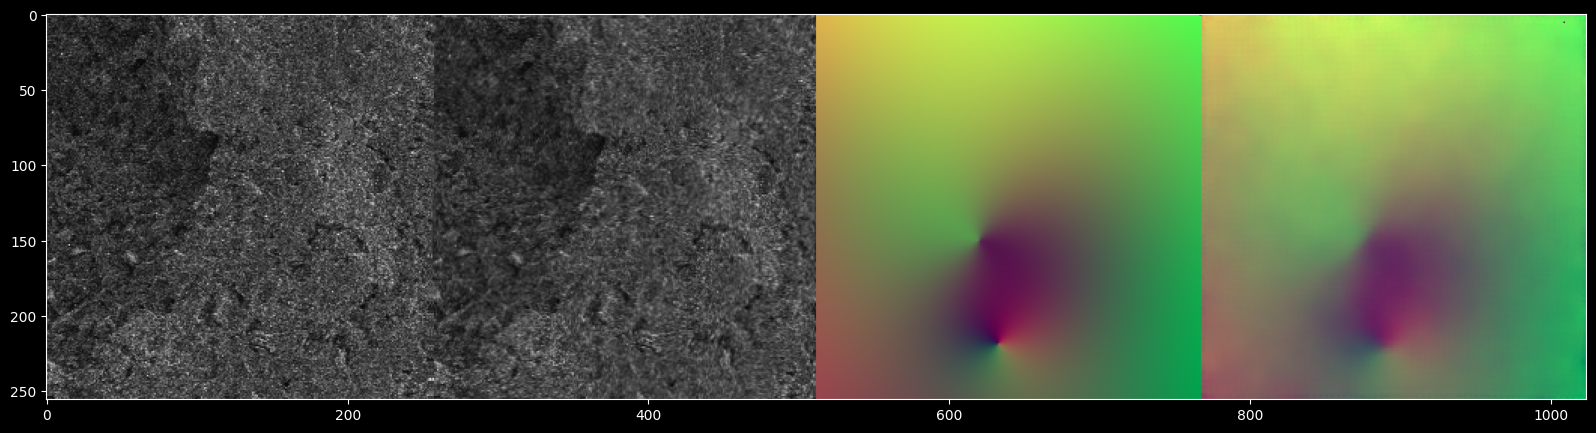

6
torch.Size([64, 2, 256, 256]) torch.Size([64, 2, 256, 256]) torch.Size([64, 2, 256, 256])
(256, 256)
0 255


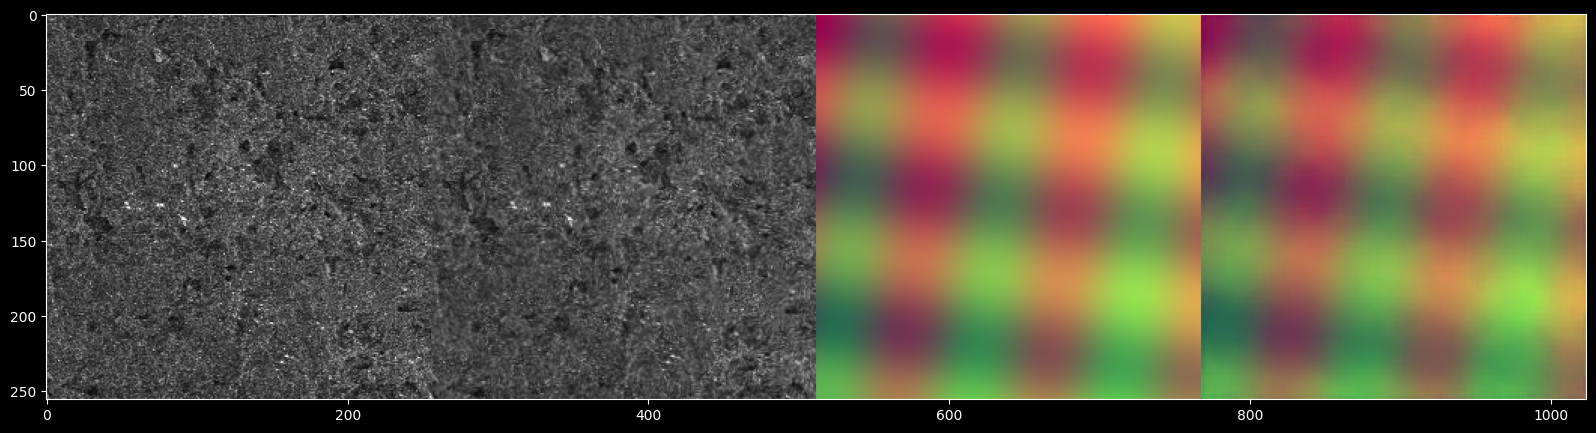

7
torch.Size([64, 2, 256, 256]) torch.Size([64, 2, 256, 256]) torch.Size([64, 2, 256, 256])
(256, 256)
0 255


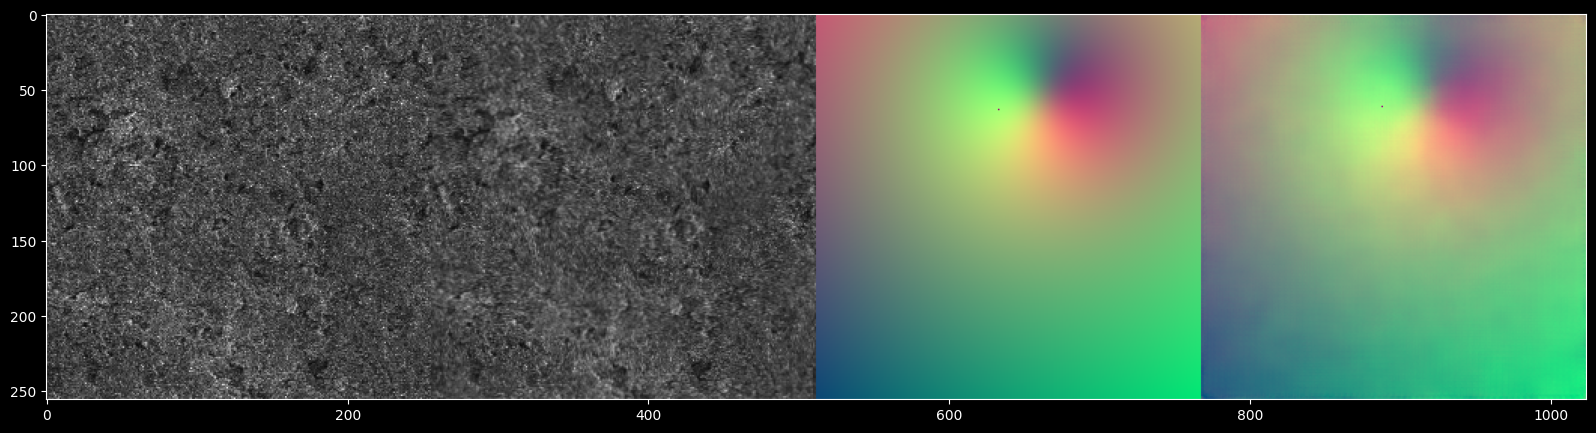

8
torch.Size([64, 2, 256, 256]) torch.Size([64, 2, 256, 256]) torch.Size([64, 2, 256, 256])
(256, 256)
0 255


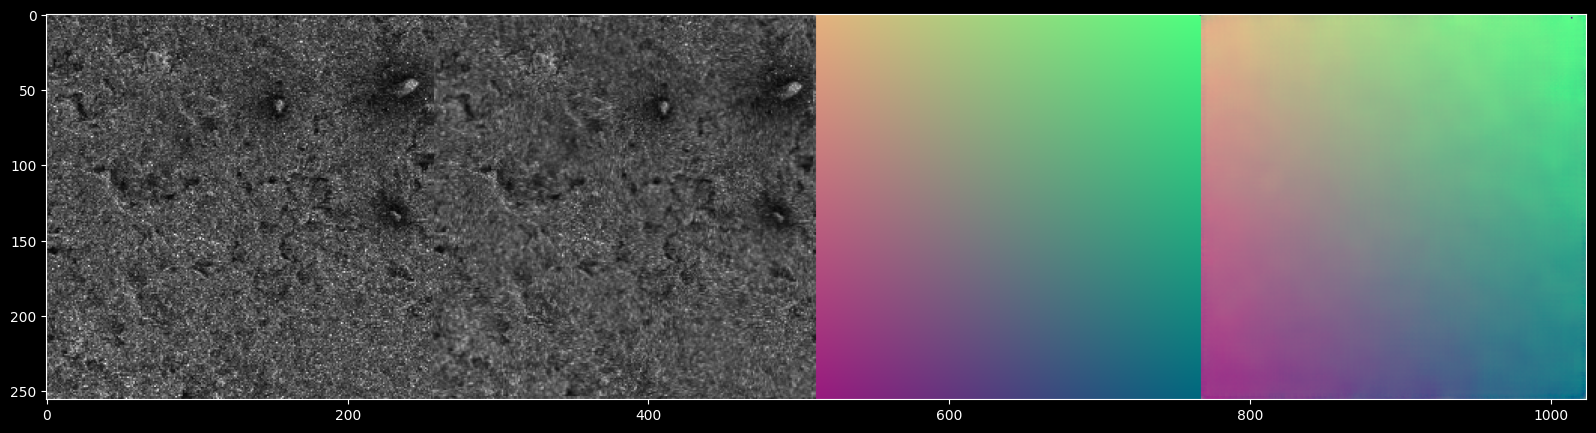

9
torch.Size([64, 2, 256, 256]) torch.Size([64, 2, 256, 256]) torch.Size([64, 2, 256, 256])
(256, 256)
0 255


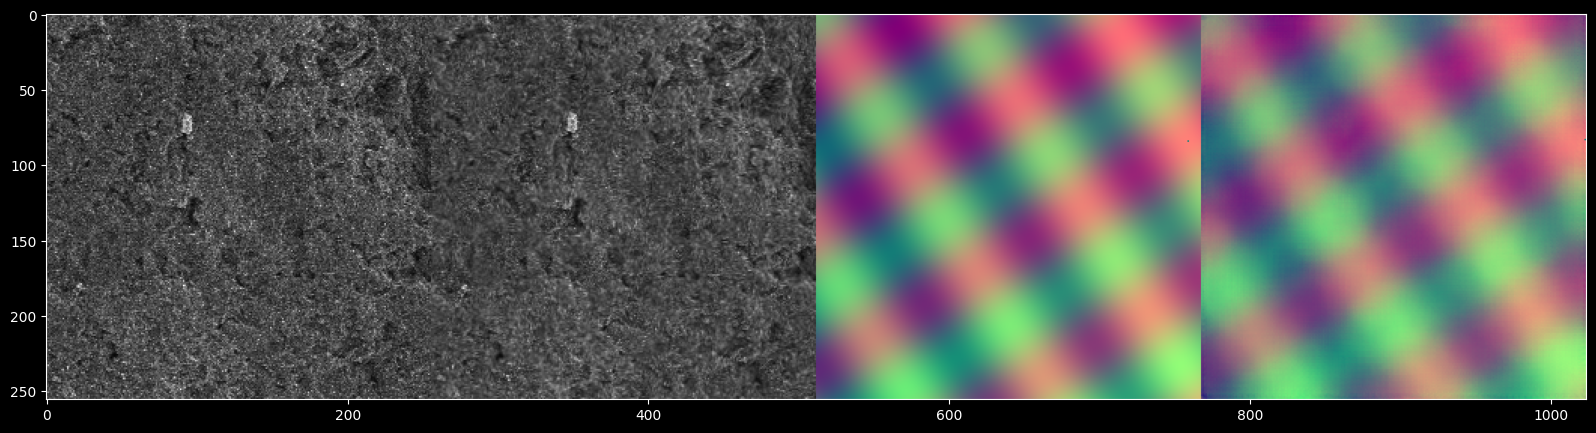

10
torch.Size([64, 2, 256, 256]) torch.Size([64, 2, 256, 256]) torch.Size([64, 2, 256, 256])
(256, 256)
0 255


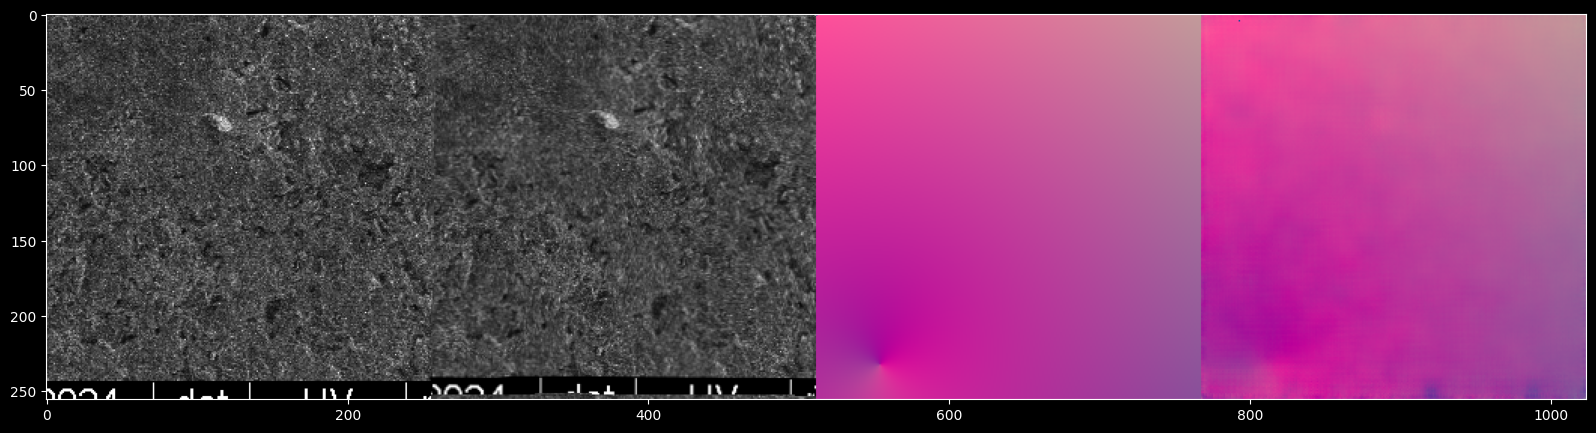

Loss: 0.387829 



In [15]:
model.eval()


test_loss= 0
i = 0
with torch.no_grad():
    for X, y in iter(validation_dataloader):
        i += 1
        if i > 10:
            break

        print(i)

        
        X, y = X.to(device), y.to(device)
        pred = model(X)
        test_loss = custom_loss(pred, y).item()

        print(X.shape, y.shape, pred.shape)

        print(X.cpu().numpy()[0][0].shape)

        
        # fig = plt.figure(figsize=(23, 5))
        # axes = fig.subplots(1, 4)

        # conver (2, 256, 256) to (256, 256, 3) and normalize
        converted_y = y[0].cpu().numpy()
        converted_y = np.vstack((converted_y, np.zeros((1, converted_y.shape[1], converted_y.shape[2]))))
        converted_y = np.transpose(converted_y, (1, 2, 0))
        converted_y = (converted_y - converted_y.min()) / (converted_y.max() - converted_y.min())

        converted_pred = pred[0].cpu().numpy()
        converted_pred = np.vstack((converted_pred, np.zeros((1, converted_pred.shape[1], converted_pred.shape[2]))))
        converted_pred = np.transpose(converted_pred, (1, 2, 0))
        converted_pred = (converted_pred - converted_pred.min()) / (converted_pred.max() - converted_pred.min())

        base_image = np.array((X[0, 0].cpu().numpy(),)*3)
        base_image = np.transpose(base_image, (1, 2, 0))
        morph_image = np.array((X[0, 1].cpu().numpy(),)*3)
        morph_image = np.transpose(morph_image, (1, 2, 0))
        combined = np.hstack((base_image, morph_image, converted_y * 256, converted_pred * 256)).astype(np.uint8)

        print(combined.min(),combined.max())

        plt.figure(figsize=(20, 5))
        plt.imshow(combined)
        plt.show()

        # axes[0].imshow(X[0, 0].cpu().numpy())
        # axes[0].set_title("Original Image")
        # axes[1].imshow(X[0, 1].cpu().numpy())
        # axes[1].set_title("Predicted Image")
        # axes[2].imshow(converted_y)
        # axes[2].set_title("Ground Truth Image")
        # axes[3].imshow(converted_pred)
        # axes[3].set_title("Predicted Image")
        # fig.tight_layout()
        # plt.show()

print(f"Loss: {test_loss:>8f} \n")